In [1]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import requests
import json
import matplotlib.pyplot as plt
from model_training_process import *
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
print(f"tf.config.list_physical_devices('GPU'): {tf.config.list_physical_devices('GPU')}")

tf.config.list_physical_devices('GPU'): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
class_df = pd.read_csv(filepath_or_buffer="..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df

,bopomofo,pinyin,hu_yin,she2_yin,hu_yin_label,she2_yin_label,class_label
0,ㄓ,zhi,純聲符,翹舌音,0,5,0
1,ㄔ,chi,純聲符,翹舌音,0,5,0
2,ㄕ,shi,純聲符,翹舌音,0,5,0
3,ㄖ,ri,純聲符,翹舌音,0,5,0
4,ㄗ,zi,純聲符,平舌音,0,6,1
...,...,...,...,...,...,...,...
402,ㄒㄩㄣ,xun,撮口呼,舌面音,4,4,20
403,ㄩㄥ,yong,撮口呼,純韻符,4,0,18
404,ㄐㄩㄥ,jiong,撮口呼,舌面音,4,4,20
405,ㄑㄩㄥ,qiong,撮口呼,舌面音,4,4,20


In [3]:
npy_file_path = glob("..\\..\\data\\*EduVer\\*.npy", recursive=True)
print(f"len(npy_file_path) = {len(npy_file_path)}")

len(npy_file_path) = 67173


In [4]:
npy_file_path_selected = list()
for npy_file in npy_file_path:
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        npy_file_path_selected.append(npy_file)
print(f"len(npy_file_path_selected) = {len(npy_file_path_selected)}")

len(npy_file_path_selected) = 66852


In [5]:
data_class_label = list()
for npy_file in tqdm(npy_file_path_selected):
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].iloc[0]
    data_class_label.append(class_label)
data_class_label = np.array(data_class_label)
print(f"len(data_class_label) = {len(data_class_label)}")

100%|██████████| 66852/66852 [00:06<00:00, 10664.90it/s]

len(data_class_label) = 66852


In [6]:
mfcc_matrix_list = list()
for npy_file in tqdm(npy_file_path_selected):
    mfcc_matrix = np.load(npy_file)
    mfcc_matrix_list.append(mfcc_matrix)
mfcc_matrix_list = np.array(mfcc_matrix_list)
print(f"len(mfcc_matrix_list) = {len(mfcc_matrix_list)}")

100%|██████████| 66852/66852 [00:24<00:00, 2769.90it/s]


len(mfcc_matrix_list) = 66852


In [7]:
best_params = json.load(open(f"..\\..\\grid_search\\method2_with_fake_data\\layer1\\best_params.json", "r"))

learning_rate = best_params["learning_rate"]
num_filters = best_params["num_filters"]
dense_units = best_params["dense_unit"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]

channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2
mfcc_dim_1 = mfcc_matrix_list.shape[1]
mfcc_dim_2 = mfcc_matrix_list.shape[2]
print(f"mfcc_dim_1: {mfcc_dim_1}")
print(f"mfcc_dim_2: {mfcc_dim_2}")

mfcc_dim_1: 13
mfcc_dim_2: 44


In [8]:
X_train, X_test, y_train, y_test = get_processed_data(
    X=mfcc_matrix_list,
    y=data_class_label,
    num_classes=num_classes,
    mfcc_dim_1=mfcc_dim_1,
    mfcc_dim_2=mfcc_dim_2,
    channel=channel,
    test_size=test_size,
)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (53481, 13, 44, 1)
y_train.shape: (53481, 407)
X_test.shape: (13371, 13, 44, 1)
y_test.shape: (13371, 407)


In [9]:
model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes, learning_rate=learning_rate, num_filters=num_filters, dense_units=dense_units)
model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/500
1672/1672 - 9s - loss: 2.1554 - accuracy: 0.3638 - val_loss: 1.7845 - val_accuracy: 0.4149 - 9s/epoch - 6ms/step
Epoch 2/500
1672/1672 - 8s - loss: 1.5855 - accuracy: 0.4905 - val_loss: 1.6982 - val_accuracy: 0.4622 - 8s/epoch - 5ms/step
Epoch 3/500
1672/1672 - 8s - loss: 1.1065 - accuracy: 0.6628 - val_loss: 1.1178 - val_accuracy: 0.6088 - 8s/epoch - 5ms/step
Epoch 4/500
1672/1672 - 8s - loss: 0.4919 - accuracy: 0.8475 - val_loss: 0.6929 - val_accuracy: 0.7887 - 8s/epoch - 5ms/step
Epoch 5/500
1672/1672 - 8s - loss: 0.4012 - accuracy: 0.8715 - val_loss: 0.8873 - val_accuracy: 0.7160 - 8s/epoch - 5ms/step
Epoch 6/500
1672/1672 - 8s - loss: 0.3397 - accuracy: 0.8904 - val_loss: 0.6178 - val_accuracy: 0.8162 - 8s/epoch - 5ms/step
Epoch 7/500
1672/1672 - 8s - loss: 0.2850 - accuracy: 0.9065 - val_loss: 0.7930 - val_accuracy: 0.7483 - 8s/epoch - 5ms/step
Epoch 8/500
1672/1672 - 8s - loss: 0.2414 - accuracy: 0.9207 - val_loss: 0.7889 - val_accuracy: 0.7547 - 8s/epoch - 5ms/step


In [10]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn method2 layer1 with fake data模型訓練已完成!"}
)

<Response [204]>

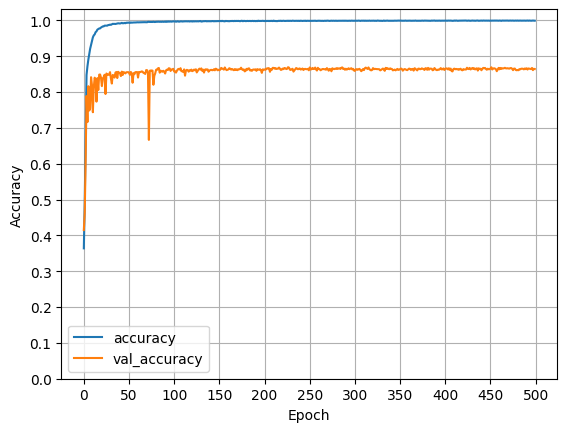

In [11]:
accuracies = model_train_info.history["accuracy"]
val_accuracies = model_train_info.history["val_accuracy"]

plt.plot(list(range(epochs)), accuracies, label = "accuracy")
plt.plot(list(range(epochs)), val_accuracies, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks = list(range(1, epochs + 1))) 
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(ticks=list(range(0, epochs + 1, 50)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [12]:
print(f"資料: {mfcc_matrix_list.shape}")
print(f"最高準確率: {max(val_accuracies)}")

資料: (66852, 13, 44)
最高準確率: 0.869194507598877


In [13]:
model.save(f".\\cnn_layer1_with_fake_model.h5")